# **Installing Uralytics**

In [ ]:
# !pip install ultralytics

# **Unzipping the images Folder**

In [3]:
import zipfile
import os

zip_path = "/content/datasets.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


# **Mounting Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Training YOLO V11 on Roboflow Dataset**

In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 nano model (smallest and fastest)
model = YOLO("yolo11n.pt")

model.train(
    data="data.yaml",
    epochs=200,
    imgsz=640,
    batch=16,
    name="rockcarving-yolov11n"
)

# # Load your trained model
# model = YOLO("/content/yolo11n.pt")

# # Predict on a new image
# results = model.predict(source="/content/07-1998M.webp", save=True, conf=0.3)

# # Optionally, show result in notebook
# results[0].show()


# **Testing On a New Dataset**

Link: https://www.bradshawfoundation.com/australia/gallery/index.php

The dataset contains 42 images

**Unzipping Australian Dataset**

In [10]:
import zipfile
import os

zip_path = "/content/Australian_RockArt.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


**Testing**

In [11]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/rockcarving-yolov11n3/weights/best.pt")

results = model.predict(
    source="/content/Australian_RockArt",
    conf=0.3,
    save=True,
    save_txt=True,
    project="runs/detect",
    name="rockcarving_test",
    exist_ok=True
)


image 1/42 /content/Australian_RockArt/hands2.jpg: 640x640 1 vandalism, 9.8ms
image 2/42 /content/Australian_RockArt/kimberley10.jpg: 448x640 1 rock art, 45.8ms
image 3/42 /content/Australian_RockArt/kimberley10b.jpg: 640x448 (no detections), 47.0ms
image 4/42 /content/Australian_RockArt/kimberley11b (1).jpg: 640x448 (no detections), 10.0ms
image 5/42 /content/Australian_RockArt/kimberley11b.jpg: 640x448 1 vandalism, 9.6ms
image 6/42 /content/Australian_RockArt/kimberley13.jpg: 448x640 1 rock art, 10.2ms
image 7/42 /content/Australian_RockArt/kimberley13b.jpg: 640x448 (no detections), 10.5ms
image 8/42 /content/Australian_RockArt/kimberley14b.jpg: 640x448 1 rock art, 10.0ms
image 9/42 /content/Australian_RockArt/kimberley15b.jpg: 640x448 1 rock art, 9.8ms
image 10/42 /content/Australian_RockArt/kimberley16.jpg: 448x640 (no detections), 10.8ms
image 11/42 /content/Australian_RockArt/kimberley16b.jpg: 640x448 1 vandalism, 11.4ms
image 12/42 /content/Australian_RockArt/kimberley17b.jpg: 

**Make bounding boxes**

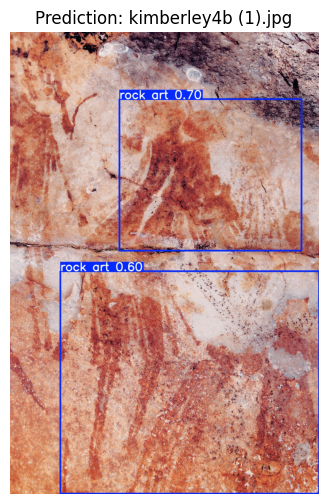

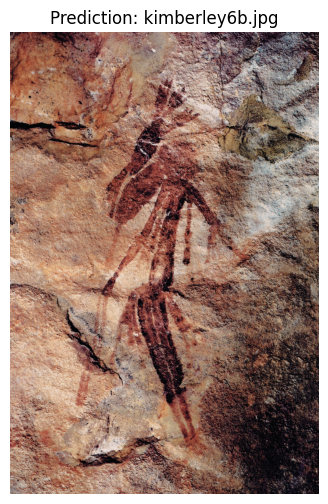

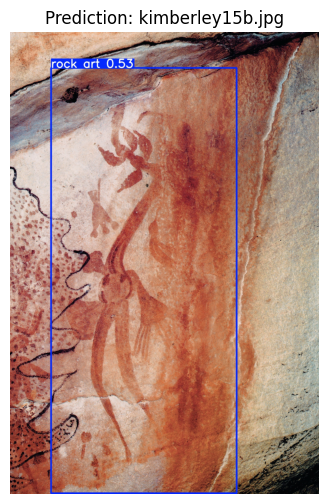

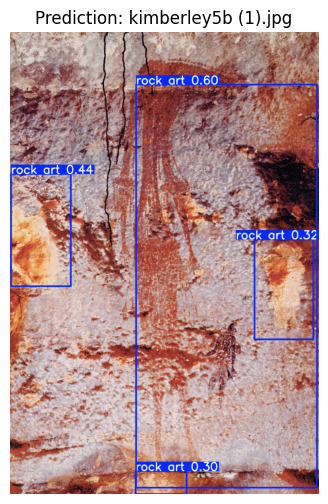

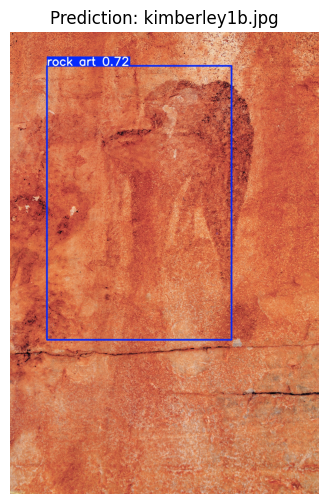

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

pred_dir = "runs/detect/rockcarving_test"

image_files = [f for f in os.listdir(pred_dir) if f.lower().endswith((".jpg", ".png"))]

num_to_display = min(5, len(image_files))
for i in range(num_to_display):
    img_path = os.path.join(pred_dir, image_files[i])
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {image_files[i]}")
    plt.axis("off")
    plt.show()


**Crop Images**

In [17]:
import os
import cv2

# === Paths ===
image_roboflow_dir = "/content/Australian_RockArt"
label_roboflow_dir = "runs/detect/rockcarving_test/labels"
output_dir = "cropped_objects"

os.makedirs(output_dir, exist_ok=True)

crop_count = 0
min_crop_size = 30
desired_size = 256

label_files = os.listdir(label_roboflow_dir)

for label_file in label_files:
    if not label_file.endswith(".txt"):
        continue

    image_name = label_file.replace(".txt", ".jpg")
    image_path = os.path.join(image_roboflow_dir, image_name)
    label_path = os.path.join(label_roboflow_dir, label_file)

    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: couldn't read {image_path}")
        continue

    height, width = image.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        _, x_center, y_center, w, h = map(float, parts)

        x1 = int((x_center - w / 2) * width)
        y1 = int((y_center - h / 2) * height)
        x2 = int((x_center + w / 2) * width)
        y2 = int((y_center + h / 2) * height)

        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(width, x2), min(height, y2)

        if x1 >= x2 or y1 >= y2:
            continue

        crop = image[y1:y2, x1:x2]

        if crop.shape[0] < min_crop_size or crop.shape[1] < min_crop_size:
            continue

        crop = cv2.resize(crop, (desired_size, desired_size), interpolation=cv2.INTER_CUBIC)

        crop_count += 1
        crop_filename = f"crop_{crop_count:03}.png"
        crop_path = os.path.join(output_dir, crop_filename)
        cv2.imwrite(crop_path, crop)

print(f"✅ Saved {crop_count} cropped images to '{output_dir}'.")


✅ Saved 31 cropped images to 'cropped_objects'.


**Display Cropped Images**

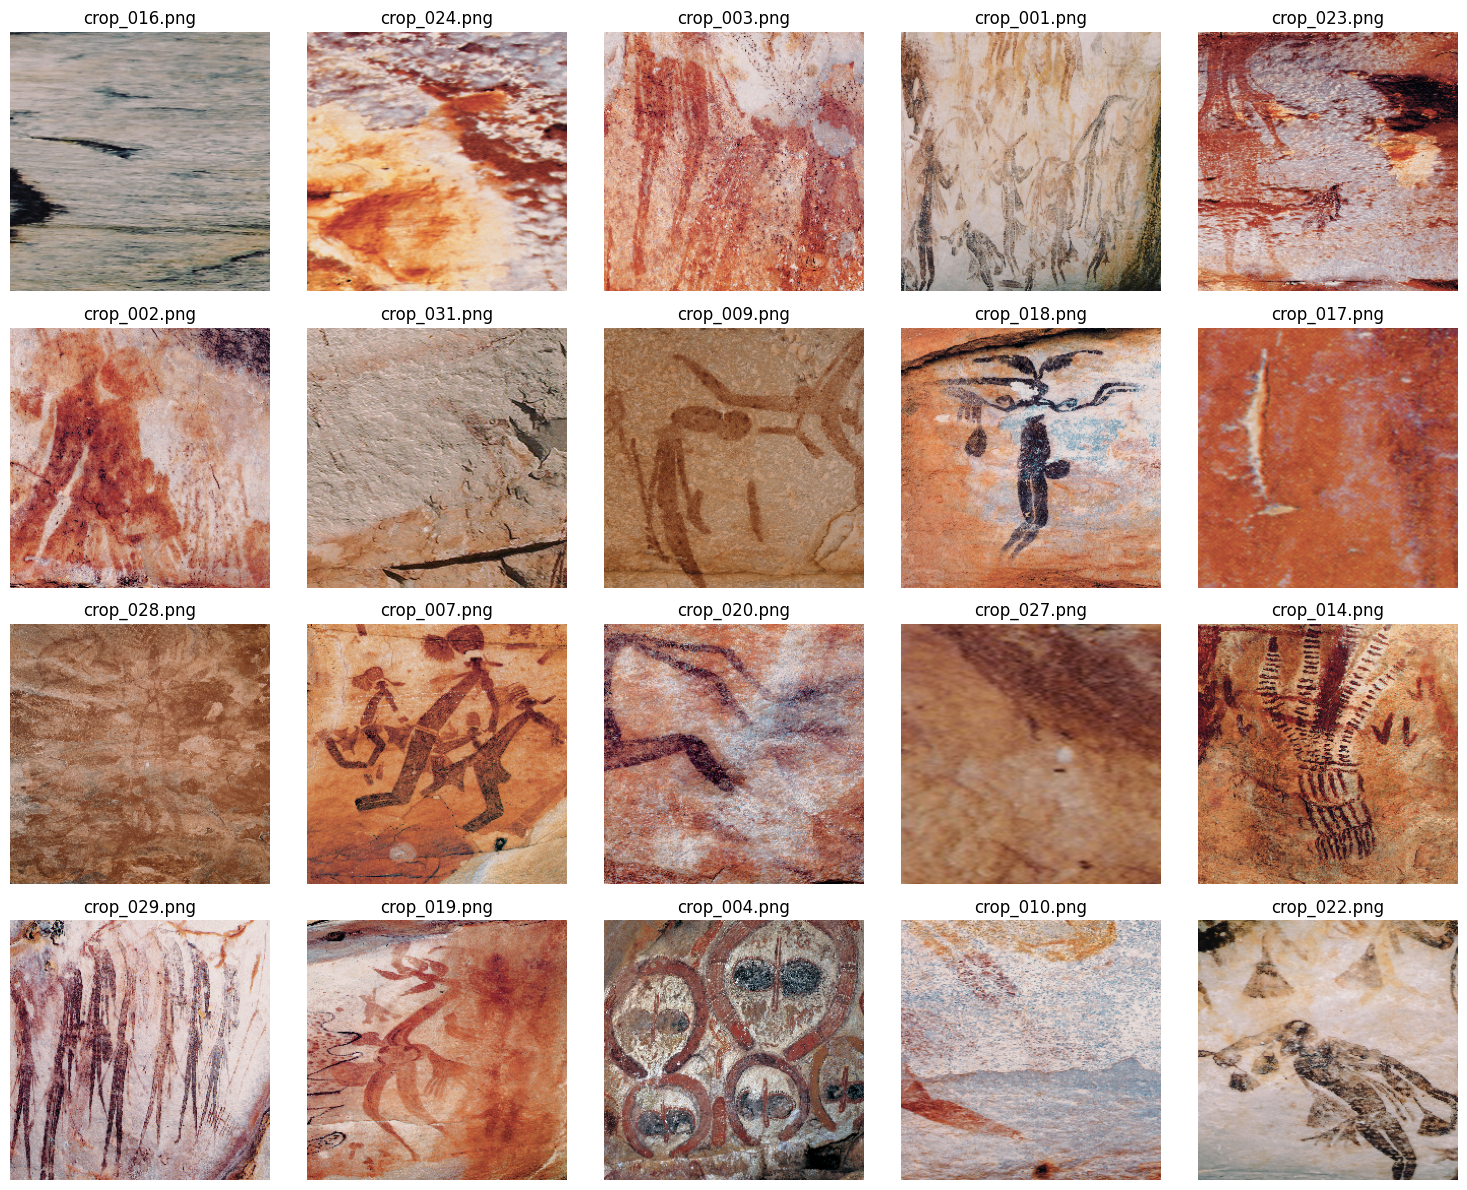

In [19]:
import os
import cv2
import matplotlib.pyplot as plt

crop_dir = "cropped_objects"

image_files = [f for f in os.listdir(crop_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

image_files = image_files[:20]

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(image_files):
        img_path = os.path.join(crop_dir, image_files[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        ax.set_title(f"{image_files[i]}")
    else:
        ax.axis("off")

    ax.axis("off")

plt.tight_layout()
plt.show()
